In [107]:
import pandas as pd
import numpy as np
import itertools

import matplotlib.pyplot as plt

import seaborn as sns
sns.set_palette('colorblind')

%matplotlib inline

# cross validation 
from sklearn.model_selection import (train_test_split, GridSearchCV)

# models
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor

In [52]:
# taken from http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
def plot_forest_importances(regressor, n=None):
    importances = regressor.feature_importances_

    important_names = my_features[importances > np.mean(importances)]
    print important_names

    std = np.std([tree.feature_importances_ for tree in regressor.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
    print("Feature ranking:")

    if n is not None: 
        threshold = min(X_test.shape[1], n)
    else:
        threshold = X_test.shape[1]
        
    for f in range(threshold):
        print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

    # Plot the feature importances of the forest
    plt.figure(figsize=(10,10))
    plt.title("Feature importances")
    plt.bar(range(threshold), importances[indices][:threshold], yerr=std[indices][:threshold], align="center")
    plt.xticks(range(threshold), my_features[indices][:threshold], rotation=90)
    plt.xlim([-1, threshold])
    plt.show()


In [23]:
train_2016 = pd.read_csv('train_2016.csv', parse_dates=['transactiondate']) # index_col = 'parcelid'
properties_2016 = pd.read_csv('properties_2016.csv', dtype={'hashottuborspa': np.bool_, 
                                                            'propertycountylandusecode': 'str',
                                                            'propertyzoningdesc': 'str',
                                                            'fireplaceflag': np.bool_,
                                                            'taxdelinquencyflag': 'str'})

In [24]:
properties_2016.hashottuborspa = properties_2016.hashottuborspa.fillna(False).astype(np.bool_)
properties_2016.propertycountylandusecode = properties_2016.propertycountylandusecode.fillna('').astype('str')
properties_2016.propertyzoningdesc = properties_2016.propertyzoningdesc.fillna('').astype('str')
properties_2016.fireplaceflag = properties_2016.fireplaceflag.fillna(False).astype(np.bool_)
properties_2016.taxdelinquencyflag = properties_2016.taxdelinquencyflag.fillna('N').astype('str')

In [25]:
df = pd.merge(train_2016, properties_2016, on='parcelid', how='left').drop_duplicates(subset='parcelid')
df.shape

(90682, 60)

In [26]:
mean_values = df.mean(axis=0)
df = df.fillna(mean_values, inplace=True)

In [27]:
df['transaction_month'] = df.transactiondate.dt.month
df['transaction_week'] = df.transactiondate.dt.week
df['transaction_hod'] = df.transactiondate.dt.hour
df['transaction_dow'] = df.transactiondate.dt.dayofweek

In [28]:
float_columns_list = sorted([str(x) for x in properties_2016.select_dtypes(include=[np.float]).columns])

uniques = {}
for column_name in float_columns_list:
    uniques[column_name] = len(properties_2016[column_name].unique())
    
categorical_columns_list = [k for (k,v) in uniques.items() if v <= 10]
non_categorical_columns_list = [k for (k,v) in uniques.items() if v > 10]

In [29]:
for column_name in categorical_columns_list + ['transaction_month', 'transaction_week', 'transaction_hod', 'transaction_dow']:
    dummies = pd.get_dummies(df[column_name]).rename(columns=lambda x: column_name + '_' + str(x)).astype(np.float)
    df = pd.concat([df, dummies], axis=1)
    print "%s is processed" % column_name

typeconstructiontypeid is processed
buildingclasstypeid is processed
fireplacecnt is processed
regionidcounty is processed
pooltypeid10 is processed
pooltypeid7 is processed
storytypeid is processed
poolcnt is processed
threequarterbathnbr is processed
fips is processed
decktypeid is processed
airconditioningtypeid is processed
architecturalstyletypeid is processed
pooltypeid2 is processed
transaction_month is processed
transaction_week is processed
transaction_hod is processed
transaction_dow is processed


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90682 entries, 0 to 90809
Columns: 181 entries, parcelid to transaction_dow_6
dtypes: bool(2), datetime64[ns](1), float64(170), int64(5), object(3)
memory usage: 124.7+ MB


In [31]:
for column_name in non_categorical_columns_list + ['logerror']:
    (column_min, column_max), column_mean = np.percentile(df[column_name], [1, 99]).tolist(), np.mean(df[column_name])
    print "For %s min/max/mean: %s, %s, %s " % (column_name, column_min, column_max, column_mean)

    df[column_name] = np.where(df[column_name] < column_min, column_mean, df[column_name])
    df[column_name] = np.where(df[column_name] > column_max, column_mean, df[column_name])

For finishedfloor1squarefeet min/max/mean: 737.0, 1928.0, 1347.72014599 
For numberofstories min/max/mean: 1.0, 2.0, 1.44079844206 
For regionidcity min/max/mean: 5465.0, 396054.0, 33762.5752301 
For finishedsquarefeet6 min/max/mean: 2293.06921241, 2293.06921241, 2293.06921241 
For regionidzip min/max/mean: 95986.0, 97329.0, 96586.1962159 
For longitude min/max/mean: -119219684.44, -117596609.0, -118198890.961 
For structuretaxvaluedollarcnt min/max/mean: 16088.0, 962352.0, 180103.150604 
For poolsizesum min/max/mean: 519.688405797, 519.688405797, 519.688405797 
For garagetotalsqft min/max/mean: 0.0, 727.0, 345.53961936 
For censustractandblock min/max/mean: 6.0371060202e+13, 6.1110079011e+13, 6.04915305082e+13 
For calculatedfinishedsquarefeet min/max/mean: 620.0, 5088.57, 1773.09686899 
For taxdelinquencyyear min/max/mean: 13.4016901408, 14.0, 13.4016901408 
For latitude min/max/mean: 33471838.06, 34684738.99, 34005465.3006 
For roomcnt min/max/mean: 0.0, 9.0, 1.4785801442 
For bedro

In [32]:
"', '".join(df.columns)

"parcelid', 'logerror', 'transactiondate', 'airconditioningtypeid', 'architecturalstyletypeid', 'basementsqft', 'bathroomcnt', 'bedroomcnt', 'buildingclasstypeid', 'buildingqualitytypeid', 'calculatedbathnbr', 'decktypeid', 'finishedfloor1squarefeet', 'calculatedfinishedsquarefeet', 'finishedsquarefeet12', 'finishedsquarefeet13', 'finishedsquarefeet15', 'finishedsquarefeet50', 'finishedsquarefeet6', 'fips', 'fireplacecnt', 'fullbathcnt', 'garagecarcnt', 'garagetotalsqft', 'hashottuborspa', 'heatingorsystemtypeid', 'latitude', 'longitude', 'lotsizesquarefeet', 'poolcnt', 'poolsizesum', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7', 'propertycountylandusecode', 'propertylandusetypeid', 'propertyzoningdesc', 'rawcensustractandblock', 'regionidcity', 'regionidcounty', 'regionidneighborhood', 'regionidzip', 'roomcnt', 'storytypeid', 'threequarterbathnbr', 'typeconstructiontypeid', 'unitcnt', 'yardbuildingsqft17', 'yardbuildingsqft26', 'yearbuilt', 'numberofstories', 'fireplaceflag', 'structu

In [33]:
N = df.shape[0]

train_df = df.iloc[:3*N/4, :].set_index('parcelid')
test_df = df.iloc[3*N/4:, :].set_index('parcelid')

print train_df.shape, test_df.shape

(68011, 180) (22671, 180)


In [63]:
all_features = np.array(['airconditioningtypeid', 'architecturalstyletypeid', 
                        'basementsqft', 'bathroomcnt', 'bedroomcnt', 'buildingclasstypeid', 
                        'buildingqualitytypeid', 'calculatedbathnbr', 'decktypeid', 
                        'finishedfloor1squarefeet', 'calculatedfinishedsquarefeet', 
                        'finishedsquarefeet12', 'finishedsquarefeet13', 'finishedsquarefeet15', 
                        'finishedsquarefeet50', 'finishedsquarefeet6', 'fips', 'fireplacecnt', 
                        'fullbathcnt', 'garagecarcnt', 'garagetotalsqft', 
                        'heatingorsystemtypeid', 'latitude', 'longitude', 'lotsizesquarefeet', 
                        'poolcnt', 'poolsizesum', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7', 
                        'propertylandusetypeid',  
                        'rawcensustractandblock', 'regionidcity', 'regionidcounty', 'regionidneighborhood', 
                        'regionidzip', 'roomcnt', 'storytypeid', 'threequarterbathnbr', 'typeconstructiontypeid', 
                        'unitcnt', 'yardbuildingsqft17', 'yardbuildingsqft26', 'yearbuilt', 'numberofstories', 
                        'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'assessmentyear', 
                        'landtaxvaluedollarcnt', 'taxamount', 'taxdelinquencyyear', 
                        'censustractandblock', 'transaction_month', 'transaction_week', 'transaction_hod', 
                        'transaction_dow', 'typeconstructiontypeid_4.0', 'typeconstructiontypeid_6.0', 
                        'typeconstructiontypeid_6.01006711409', 'typeconstructiontypeid_13.0', 
                        'buildingclasstypeid_4.0', 'fireplacecnt_1.0', 'fireplacecnt_1.18787120975', 
                        'fireplacecnt_2.0', 'fireplacecnt_3.0', 'fireplacecnt_4.0', 'fireplacecnt_5.0', 
                        'regionidcounty_1286.0', 'regionidcounty_2061.0', 'regionidcounty_2525.45696062', 
                        'regionidcounty_3101.0', 'pooltypeid10_1.0', 'pooltypeid7_1.0', 'storytypeid_7.0', 
                        'poolcnt_1.0', 'threequarterbathnbr_1.0', 'threequarterbathnbr_1.00875291764', 
                        'threequarterbathnbr_2.0', 'threequarterbathnbr_3.0', 'threequarterbathnbr_4.0', 
                        'fips_6037.0', 'fips_6048.87281198', 'fips_6059.0', 'fips_6111.0', 'decktypeid_66.0', 
                        'airconditioningtypeid_1.0', 'airconditioningtypeid_1.81522192848', 
                        'airconditioningtypeid_3.0', 'airconditioningtypeid_5.0', 'airconditioningtypeid_9.0', 
                        'airconditioningtypeid_11.0', 'airconditioningtypeid_13.0', 'architecturalstyletypeid_2.0', 
                        'architecturalstyletypeid_3.0', 'architecturalstyletypeid_7.0', 
                        'architecturalstyletypeid_7.23076923077', 'architecturalstyletypeid_8.0', 
                        'architecturalstyletypeid_10.0', 'architecturalstyletypeid_21.0', 'pooltypeid2_1.0', 
                        'transaction_month_1', 'transaction_month_2', 'transaction_month_3', 'transaction_month_4', 
                        'transaction_month_5', 'transaction_month_6', 'transaction_month_7', 'transaction_month_8', 
                        'transaction_month_9', 'transaction_month_10', 'transaction_month_11', 
                        'transaction_month_12', 'transaction_week_1', 'transaction_week_2', 
                        'transaction_week_3', 'transaction_week_4', 'transaction_week_5', 'transaction_week_6', 
                        'transaction_week_7', 'transaction_week_8', 'transaction_week_9', 'transaction_week_10', 
                        'transaction_week_11', 'transaction_week_12', 'transaction_week_13', 'transaction_week_14', 
                        'transaction_week_15', 'transaction_week_16', 'transaction_week_17', 'transaction_week_18', 
                        'transaction_week_19', 'transaction_week_20', 'transaction_week_21', 'transaction_week_22', 
                        'transaction_week_23', 'transaction_week_24', 'transaction_week_25', 'transaction_week_26', 
                        'transaction_week_27', 'transaction_week_28', 'transaction_week_29', 'transaction_week_30', 
                        'transaction_week_31', 'transaction_week_32', 'transaction_week_33', 'transaction_week_34', 
                        'transaction_week_35', 'transaction_week_36', 'transaction_week_37', 'transaction_week_38', 
                        'transaction_week_39', 'transaction_week_40', 'transaction_week_41', 'transaction_week_42', 
                        'transaction_week_43', 'transaction_week_44', 'transaction_week_45', 'transaction_week_46', 
                        'transaction_week_47', 'transaction_week_48', 'transaction_week_49', 'transaction_week_50', 
                        'transaction_week_51', 'transaction_week_52', 'transaction_week_53', 'transaction_hod_0', 
                        'transaction_dow_0', 'transaction_dow_1', 'transaction_dow_2', 'transaction_dow_3', 
                        'transaction_dow_4', 'transaction_dow_5', 'transaction_dow_6'])

In [89]:
my_features = np.array(['bathroomcnt', 'bedroomcnt', 'buildingqualitytypeid', 'calculatedbathnbr',
 'calculatedfinishedsquarefeet', 'finishedsquarefeet12',
 'finishedsquarefeet15', 'garagetotalsqft', 'heatingorsystemtypeid',
 'latitude', 'longitude', 'lotsizesquarefeet', 'propertylandusetypeid',
 'rawcensustractandblock', 'regionidcity', 'regionidneighborhood',
 'regionidzip', 'yearbuilt', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt',
 'landtaxvaluedollarcnt', 'taxamount', 'censustractandblock'])

In [105]:
len(my_features)

23

In [64]:
todo_features = ['hashottuborspa', 'propertycountylandusecode', 'propertyzoningdesc', 'fireplaceflag', 'taxdelinquencyflag']

In [90]:
X = train_df[my_features].copy()
y = train_df.logerror.copy()

In [91]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [98]:
from sklearn import linear_model

linregr = linear_model.LinearRegression()
    
linregr.fit(X_train, y_train)
y_predict = linregr.predict(X_test)

/Users/ikononenko/tensorflow/lib/python2.7/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


In [104]:
linregr.score(X_test, y_test)

0.0083884963656177813

In [69]:
%%time
rf = RandomForestRegressor(n_estimators=10)
rf.fit(X_train.values, y_train.values)
y_prediction = rf.predict(X_test.values)
y_probability = np.ravel(y_test.values)

CPU times: user 13 s, sys: 194 ms, total: 13.2 s
Wall time: 13.4 s


In [70]:
print("Score: %f" % rf.score(X_test, y_test))           

Score: -0.102629


['calculatedfinishedsquarefeet' 'finishedsquarefeet12' 'latitude'
 'longitude' 'lotsizesquarefeet' 'regionidzip' 'yearbuilt'
 'structuretaxvaluedollarcnt' 'taxvaluedollarcnt' 'landtaxvaluedollarcnt'
 'taxamount']
Feature ranking:
1. feature 18 (0.087891)
2. feature 10 (0.084226)
3. feature 11 (0.084128)
4. feature 21 (0.083473)
5. feature 9 (0.081327)
6. feature 20 (0.075532)
7. feature 19 (0.071429)
8. feature 17 (0.067504)
9. feature 4 (0.054097)
10. feature 5 (0.049709)
11. feature 16 (0.045312)
12. feature 15 (0.030442)
13. feature 13 (0.029379)
14. feature 14 (0.028916)
15. feature 22 (0.027464)
16. feature 1 (0.022598)
17. feature 7 (0.017203)
18. feature 0 (0.011240)
19. feature 3 (0.010736)
20. feature 2 (0.010040)


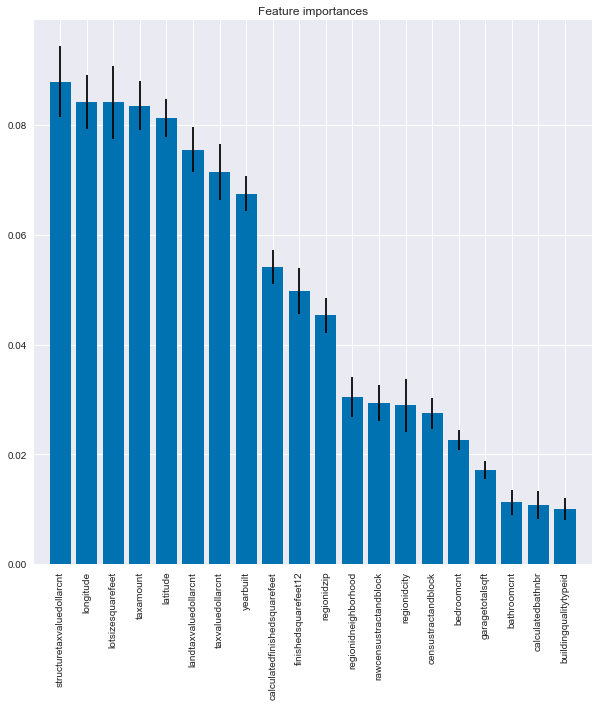

In [71]:
plot_forest_importances(rf, 20)

In [110]:
param_grid = {'n_estimators': [100,300,500,1000], 'max_features': [10,15,20],'max_depth':[5,10,15]}
rfr = GridSearchCV(estimator=RandomForestRegressor(), 
                   fit_params = {'sample_weight': np.array([30 if i != 0 else 1 for i in y_train])},
                   param_grid=param_grid, n_jobs=-1, cv=5, verbose=1)
rfr.fit(X_train, y_train)
print(rfr.best_estimator_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed: 88.4min finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=15,
           max_features=10, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)


In [111]:
rfr.best_score_

0.019199398372594066

In [94]:
import lightgbm as lgb
import gc

params = {}
params['learning_rate'] = 0.002
params['boosting_type'] = 'gbdt'
params['objective'] = 'regression'
params['metric'] = 'mae'
params['sub_feature'] = 0.5
params['num_leaves'] = 60
params['min_data'] = 500
params['min_hessian'] = 1

ds_train = lgb.Dataset(X_train, label=y_train)
ds_test = lgb.Dataset(X_test, label=y_test)

watchlist = [ds_test]

clf = lgb.train(params, ds_train, 500, watchlist)

[1]	valid_0's l1: 0.0528144
[2]	valid_0's l1: 0.0528129
[3]	valid_0's l1: 0.0528118
[4]	valid_0's l1: 0.0528108
[5]	valid_0's l1: 0.0528099
[6]	valid_0's l1: 0.0528088
[7]	valid_0's l1: 0.0528079
[8]	valid_0's l1: 0.0528067
[9]	valid_0's l1: 0.0528055
[10]	valid_0's l1: 0.0528044
[11]	valid_0's l1: 0.0528031
[12]	valid_0's l1: 0.052802
[13]	valid_0's l1: 0.0528005
[14]	valid_0's l1: 0.0527989
[15]	valid_0's l1: 0.0527977
[16]	valid_0's l1: 0.0527965
[17]	valid_0's l1: 0.0527947
[18]	valid_0's l1: 0.0527936
[19]	valid_0's l1: 0.0527925
[20]	valid_0's l1: 0.0527911
[21]	valid_0's l1: 0.05279
[22]	valid_0's l1: 0.0527892
[23]	valid_0's l1: 0.0527882
[24]	valid_0's l1: 0.052787
[25]	valid_0's l1: 0.0527855
[26]	valid_0's l1: 0.0527842
[27]	valid_0's l1: 0.0527825
[28]	valid_0's l1: 0.0527811
[29]	valid_0's l1: 0.0527802
[30]	valid_0's l1: 0.0527784
[31]	valid_0's l1: 0.0527777
[32]	valid_0's l1: 0.0527769
[33]	valid_0's l1: 0.0527758
[34]	valid_0's l1: 0.0527744
[35]	valid_0's l1: 0.052772

[280]	valid_0's l1: 0.0525965
[281]	valid_0's l1: 0.0525957
[282]	valid_0's l1: 0.0525944
[283]	valid_0's l1: 0.0525935
[284]	valid_0's l1: 0.0525924
[285]	valid_0's l1: 0.052592
[286]	valid_0's l1: 0.0525918
[287]	valid_0's l1: 0.0525913
[288]	valid_0's l1: 0.0525908
[289]	valid_0's l1: 0.05259
[290]	valid_0's l1: 0.0525891
[291]	valid_0's l1: 0.0525887
[292]	valid_0's l1: 0.0525883
[293]	valid_0's l1: 0.0525877
[294]	valid_0's l1: 0.0525871
[295]	valid_0's l1: 0.0525861
[296]	valid_0's l1: 0.0525854
[297]	valid_0's l1: 0.0525851
[298]	valid_0's l1: 0.0525852
[299]	valid_0's l1: 0.0525839
[300]	valid_0's l1: 0.0525835
[301]	valid_0's l1: 0.0525831
[302]	valid_0's l1: 0.0525826
[303]	valid_0's l1: 0.0525822
[304]	valid_0's l1: 0.0525817
[305]	valid_0's l1: 0.0525808
[306]	valid_0's l1: 0.0525799
[307]	valid_0's l1: 0.0525794
[308]	valid_0's l1: 0.0525783
[309]	valid_0's l1: 0.052578
[310]	valid_0's l1: 0.0525778
[311]	valid_0's l1: 0.052577
[312]	valid_0's l1: 0.0525765
[313]	valid_0's

In [95]:
y_prediction = clf.predict(X_test)

In [97]:
clf.best_score['valid_0']['l1']

0.052515012513006019

In [ ]:
import tflearn as tf

# input layer
net = tf.input_data(shape=[None, X_train.shape[1]])

# hidden layers
net = tf.fully_connected(net, 32, activation='relu')
net = tf.fully_connected(net, 64, activation='relu')
net = tf.fully_connected(net, 64, activation='relu')
net = tf.fully_connected(net, 32, activation='relu')

# output layer
net = tf.fully_connected(net, 1, activation='linear')

net = tf.regression(net, optimizer='adam', loss='mean_square', metric='R2', learning_rate=0.001)

net = tf.DNN(net, tensorboard_verbose=0)

net.fit(X_train, y_train, n_epoch=10, validation_set=0.1, show_metric=True, batch_size=128, shuffle=True,
       snapshot_epoch=True)

### Submission

In [72]:
sample_submission = pd.read_csv('sample_submission.csv')

In [73]:
import datetime
today = datetime.date.today().strftime("%d-%m-%Y")

In [74]:
sample_submission['parcelid'] = sample_submission['ParcelId']
submission = sample_submission.merge(properties_2016, on='parcelid', how='left')

X_test = submission[my_features]
X_test = X_test.fillna(mean_values, inplace=True)
prediction = rf.predict(X_test.values)

for column_name in submission.columns[submission.columns != 'ParcelId']:
    submission[column_name] = prediction

submission.to_csv('submission_%s.csv' % today, index=False, float_format='%.4f')